In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from SSTImportanceSampling  import Preprocessor, ImportanceSampler, StormDepthProcessor, AdaptParams, AdaptiveMixtureSampler

from production.utils import summarize_depths_by_return_period

<h3> Preprocess </h3>

In [3]:
watershed_names = ["Trinity","Kanawha","Duwamish","Denton"]

In [4]:
#Run and store data
watersheds = {}

for wname in watershed_names:
    print(f"\n=== Processing {wname} ===")
    ws = Preprocessor(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/0_source/{wname}/config.json",
        output_folder=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}"
    )
    ws.run()
    watersheds[wname] = ws


=== Processing Trinity ===


Valid mask via VCR: 100%|██████████| 440/440 [00:00<00:00, 717.66it/s]



=== Processing Kanawha ===


Valid mask via VCR: 100%|██████████| 440/440 [00:00<00:00, 1261.60it/s]



=== Processing Duwamish ===


Valid mask via VCR: 100%|██████████| 440/440 [00:00<00:00, 1884.27it/s]



=== Processing Denton ===


Valid mask via VCR: 100%|██████████| 440/440 [00:00<00:00, 726.32it/s]


In [4]:
#Load data
watersheds = {}

for wname in watershed_names:
    ws = Preprocessor.load(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}/config.json"
    )
    watersheds[wname] = ws

Full Monte Depths

In [6]:
#Run full Monte Carlo simulations
sampler = ImportanceSampler(
    distribution="uniform",
    params={},
    num_simulations=20_000,
    num_realizations=50
)

for wname, ws in watersheds.items():
    samples = sampler.sample(data=ws)
    depths = StormDepthProcessor(ws).run(samples, n_jobs=-1)
    depths.to_parquet(
        f"/workspaces/Importance-Sampling-for-SST/data/2_production/{wname}/fullmonte_depths.pq",
        index=False
    )
    print(f"{wname} done.")

Trinity done.
Kanawha done.
Duwamish done.
Denton done.


In [7]:
#Load full Monte Carlo simulation results
depths_all = {}
for wname in watersheds.keys():
    path = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{wname}/fullmonte_depths.pq"
    depths_all[wname] = pd.read_parquet(path)

Summarize

In [8]:
for wname, df_depths in depths_all.items():
    if df_depths.empty:
        print(f"Skipping {wname}: no depths")
        continue
    
    summary = summarize_depths_by_return_period(
        df=df_depths,
        precip_col="precip_avg_mm",
        exc_col="exc_prb",
        realization_col="realization",
        k=10.0,
        rp_min=2,
        rp_max_cap=2000,
    )
    out_path = f"/workspaces/Importance-Sampling-for-SST/data/2_production/{wname}/fullmonte_summary.pq"
    summary.to_parquet(out_path, index=False)
    print(f"Saved summary for {wname} to {out_path}")

Saved summary for Trinity to /workspaces/Importance-Sampling-for-SST/data/2_production/Trinity/fullmonte_summary.pq
Saved summary for Kanawha to /workspaces/Importance-Sampling-for-SST/data/2_production/Kanawha/fullmonte_summary.pq
Saved summary for Duwamish to /workspaces/Importance-Sampling-for-SST/data/2_production/Duwamish/fullmonte_summary.pq
Saved summary for Denton to /workspaces/Importance-Sampling-for-SST/data/2_production/Denton/fullmonte_summary.pq


Plot

Saved: /workspaces/Importance-Sampling-for-SST/data/2_production/plots/fullmonte_precip_frequency.png


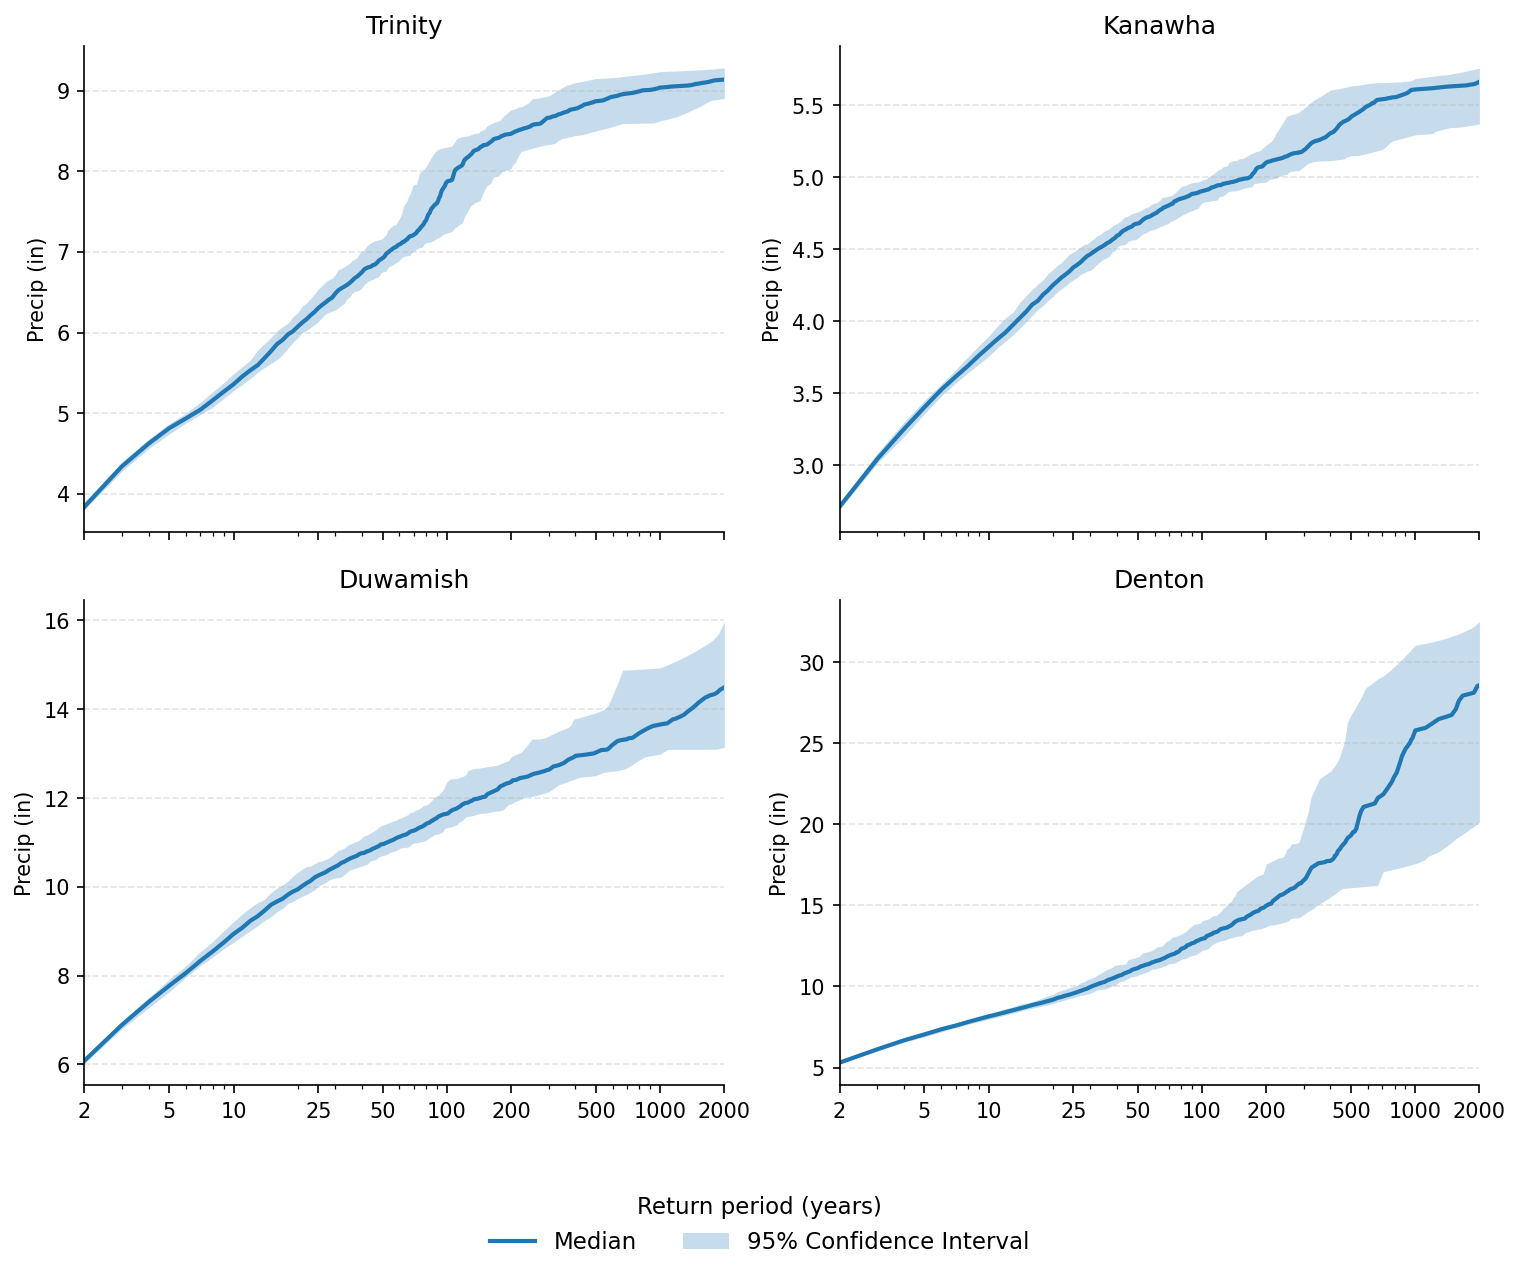

In [9]:
# --- inputs ---
base_dir = "/workspaces/Importance-Sampling-for-SST/data/2_production"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

# --- plotting ---
x_ticks = [2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000]
x_min, x_max = 2, 2000

fig = plt.figure(figsize=(12, 9), dpi=150)
gs = GridSpec(2, 2, figure=fig, wspace=0.18, hspace=0.14)

axes = []
for i, w in enumerate(watershed_names):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    axes.append(ax)
    d = summaries[w]

    # 95% ribbon
    ax.fill_between(
        d["RP"], d["ci95_low_in"], d["ci95_high_in"],
        alpha=0.25, linewidth=0, color="C0"  # blueish
    )
    # median line
    ax.plot(d["RP"], d["median_in"], linewidth=2.0, color="C0")

    ax.set_xscale("log")
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.tick_params(axis="x", which="major", length=4)
    ax.margins(x=0)  # no extra space

    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.35)
    ax.set_ylabel("Precip (in)")
    ax.set_title(w, fontsize=12, pad=6)

# show x tick labels only on bottom row
for ax in axes[:2]:
    ax.set_xticklabels([])

# remove top/right spines
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# global x label
fig.text(0.5, 0.02, "Return period (years)", ha="center", va="center", fontsize=11)

# --- add one legend at bottom ---
legend_elements = [
    Line2D([0], [0], color="C0", lw=2, label="Median"),
    Patch(facecolor="C0", alpha=0.25, label="95% Confidence Interval")
]
fig.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=2,
    frameon=False,
    fontsize=11
)

# save high-res PNG
out_png = os.path.join("/workspaces/Importance-Sampling-for-SST/data/2_production/plots/fullmonte_precip_frequency.png")
fig.savefig(out_png, dpi=300, bbox_inches="tight")

print(f"Saved: {out_png}")
